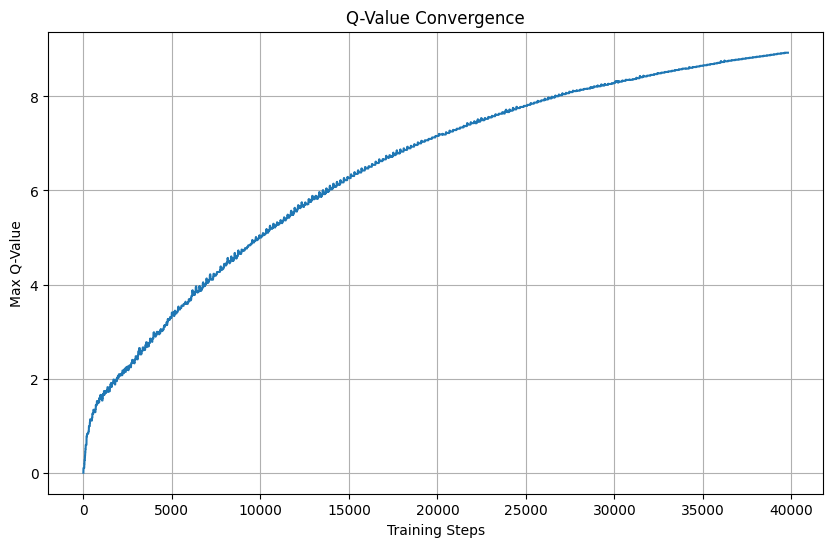

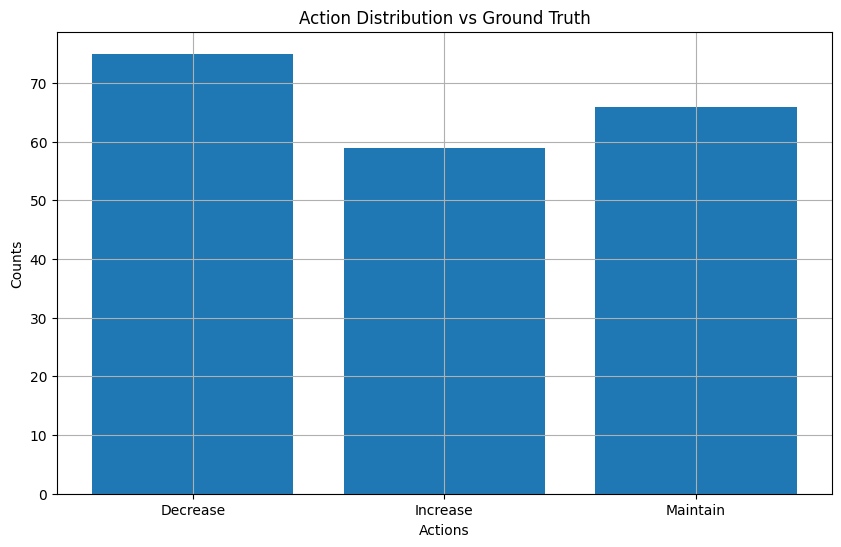

Estimated Energy Reduction: 34.50%


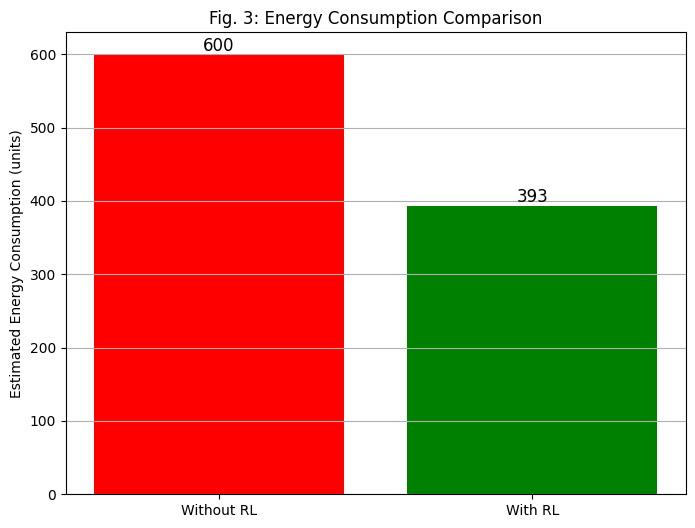

In [89]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import collections

# Define mappings and discretization functions
TIME_MAPPING = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
ACTION_MAPPING = {'Decrease': 0, 'Increase': 1, 'Maintain': 2}

def discretize_temp(temp):
    return round(temp / 3) * 3

def discretize_humidity(humidity):
    return round(humidity / 5) * 5

# Load and preprocess data
df = pd.read_csv(r"C:\Users\manga\Downloads\Mangal DA\smart_room_data_balanced.csv")
df["Time_of_Day"] = df["Time_of_Day"].map(TIME_MAPPING)
df["HVAC_Action"] = df["HVAC_Action"].map(ACTION_MAPPING)
df["External_Temp"] = df["External_Temp"].apply(discretize_temp)
df["Room_Temp"] = df["Room_Temp"].apply(discretize_temp)
df["Humidity"] = df["Humidity"].apply(discretize_humidity)

# Create state mapping
features = ["External_Temp", "Room_Temp", "Humidity", "Time_of_Day", "Occupancy"]
state_to_idx = {tuple(row): idx for idx, row in enumerate(df[features].drop_duplicates().values)}
Q = np.zeros((len(state_to_idx), 3))

# Initialize tracking for visualization
q_values = []
predicted_actions = []
actual_actions = df["HVAC_Action"].values

# Training loop with Q-value tracking
for _ in range(200):  # Episodes
    for i in range(len(df) - 1):
        cur_row, next_row = df.iloc[i], df.iloc[i + 1]
        cur_state, next_state = tuple(cur_row[features]), tuple(next_row[features])
        state_idx = state_to_idx[cur_state]
        next_idx = state_to_idx.get(next_state, state_idx)

        # ε-greedy action selection
        action = random.randint(0, 2) if random.random() < 0.2 else np.argmax(Q[state_idx])
        reward = 1 if action == cur_row["HVAC_Action"] else -1

        # Q-value update
        Q[state_idx, action] += 0.1 * (reward + 0.9 * np.max(Q[next_idx]) - Q[state_idx, action])
        q_values.append(np.max(Q))

# Helper function: Find closest state if exact not found
def find_closest_state(state, state_dict):
    min_dist = float('inf')
    closest = None
    for s in state_dict:
        dist = np.linalg.norm(np.array(state) - np.array(s))
        if dist < min_dist:
            min_dist = dist
            closest = s
    return state_dict[closest]

# Prediction function (cleaned)
def predict_action(new_input):
    try:
        processed = [
            discretize_temp(new_input[0]), 
            discretize_temp(new_input[1]),
            discretize_humidity(new_input[2]), 
            TIME_MAPPING[new_input[3]], 
            new_input[4]
        ]
        state = tuple(processed)
        if state in state_to_idx:
            state_idx = state_to_idx[state]
        else:
            state_idx = find_closest_state(state, state_to_idx)
        action_idx = np.argmax(Q[state_idx])
        return [k for k, v in ACTION_MAPPING.items() if v == action_idx][0]
    except:
        return "Maintain"

# Predict actions based on Q-table
predicted_actions = []
for i in range(len(df)):
    row = df.iloc[i]
    state = tuple(row[features])
    if state in state_to_idx:
        predicted_action = np.argmax(Q[state_to_idx[state]])
    else:
        idx = find_closest_state(state, state_to_idx)
        predicted_action = np.argmax(Q[idx])
    predicted_actions.append(predicted_action)

# Count predicted actions
action_counter = collections.Counter(predicted_actions)

# Visualization: Q-value convergence
plt.figure(figsize=(10, 6))
plt.plot(q_values)
plt.xlabel('Training Steps')
plt.ylabel('Max Q-Value')
plt.title('Q-Value Convergence')
plt.grid()
plt.show()

# Visualization: Action distribution
plt.figure(figsize=(10, 6))
plt.bar(list(ACTION_MAPPING.keys()), [action_counter[action] for action in ACTION_MAPPING.values()])
plt.xlabel('Actions')
plt.ylabel('Counts')
plt.title('Action Distribution vs Ground Truth')
plt.grid()
plt.show()

# Energy consumption estimation
energy_cost = {0: 2, 1: 3, 2: 1}  # Decrease, Increase, Maintain
baseline_energy = len(df) * energy_cost[1]
rl_energy = sum([energy_cost[a] for a in predicted_actions])
reduction_percent = ((baseline_energy - rl_energy) / baseline_energy) * 100
print(f"Estimated Energy Reduction: {reduction_percent:.2f}%")

# Plot energy comparison
plt.figure(figsize=(8, 6))
plt.bar(['Without RL', 'With RL'], [baseline_energy, rl_energy], color=['red', 'green'])
plt.ylabel('Estimated Energy Consumption (units)')
plt.title('Fig. 3: Energy Consumption Comparison')
for idx, val in enumerate([baseline_energy, rl_energy]):
    plt.text(idx, val + 5, f'{val}', ha='center', fontsize=12)
plt.grid(True, axis='y')
plt.show()



In [85]:
# --- User Input Prediction ---
print("\n--- Smart Room HVAC Action Prediction ---")
try:
    ext_temp = float(input("Enter External Temperature (°C): "))
    room_temp = float(input("Enter Room Temperature (°C): "))
    humidity = float(input("Enter Humidity (%): "))
    time_of_day = input("Enter Time of Day (Morning, Afternoon, Evening, Night): ")
    occupancy = int(input("Enter Occupancy Count: "))

    user_input = [ext_temp, room_temp, humidity, time_of_day, occupancy]
    action_result = predict_action(user_input)
    print(f"\nRecommended HVAC Action: {action_result}")

except Exception as e:
    print(f"Invalid input! Error: {e}")



--- Smart Room HVAC Action Prediction ---


Enter External Temperature (°C):  29
Enter Room Temperature (°C):  26
Enter Humidity (%):  60
Enter Time of Day (Morning, Afternoon, Evening, Night):  Afternoon
Enter Occupancy Count:  5



Recommended HVAC Action: Decrease
